# Plot results of changing L

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from cymr import cmr
from psifr import fr

res_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])

In [2]:
data = pd.read_csv(res_dir / 'benchmark.csv')
study_data = fr.filter_data(data, trial_type='study')
patterns = cmr.load_patterns(res_dir / 'cfr_patterns.hdf5')

model_name = 'cmrs_fcf-loc-cat-use'
fit = pd.read_csv(fit_dir / model_name / 'fit.csv')
param_def = cmr.read_config(fit_dir / model_name / 'parameters.json')
params = fit.mean().to_dict()

In [3]:
model = cmr.CMR()
sweep_param = {
    'Lfc': np.array([.01, .25, .5, .75, .99]), 
    'Lcf': np.array([.01, .25, .5, .75, .99]),
}
param_names = list(sweep_param.keys())
results = model.parameter_sweep(
    study_data,
    params,
    None,
    sweep_param,
    param_def,
    patterns,
    n_rep=3,
)

In [4]:
sim = results.groupby(level=[0, 1]).apply(
    fr.merge_free_recall, study_keys=['category']
)

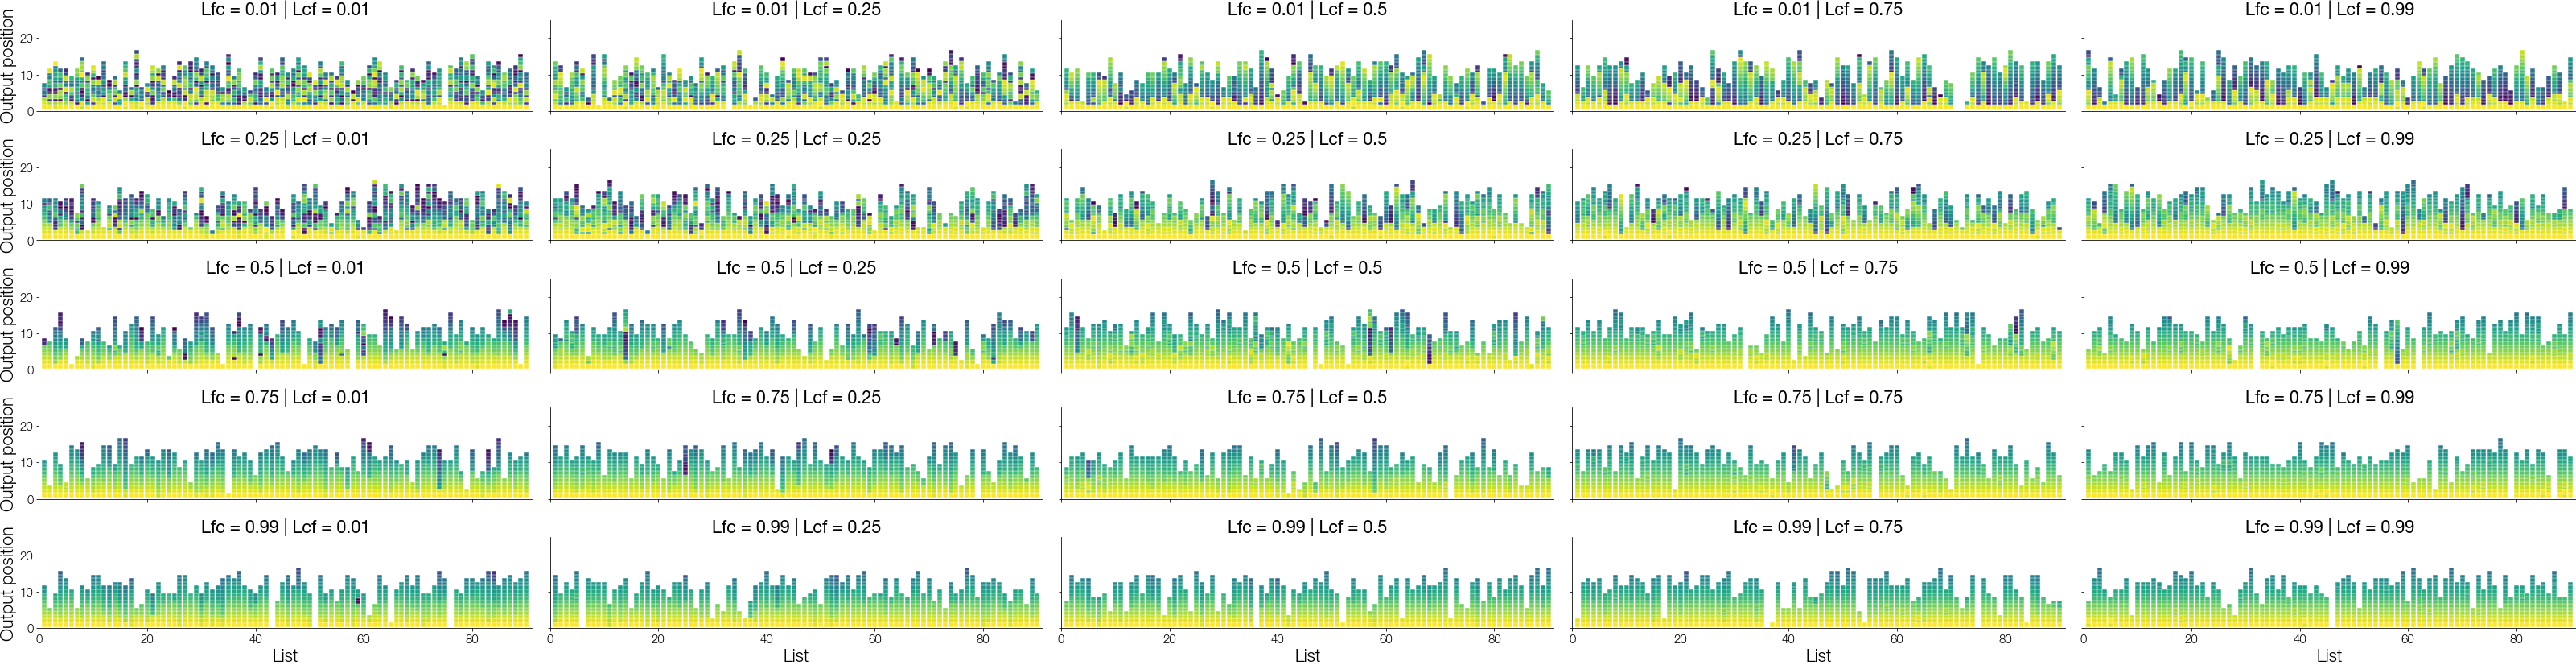

In [5]:
g = fr.plot_raster(
    fr.reset_list(sim.reset_index()),
    row=param_names[0],
    col=param_names[1],
    orientation='horizontal',
    length=9,
);

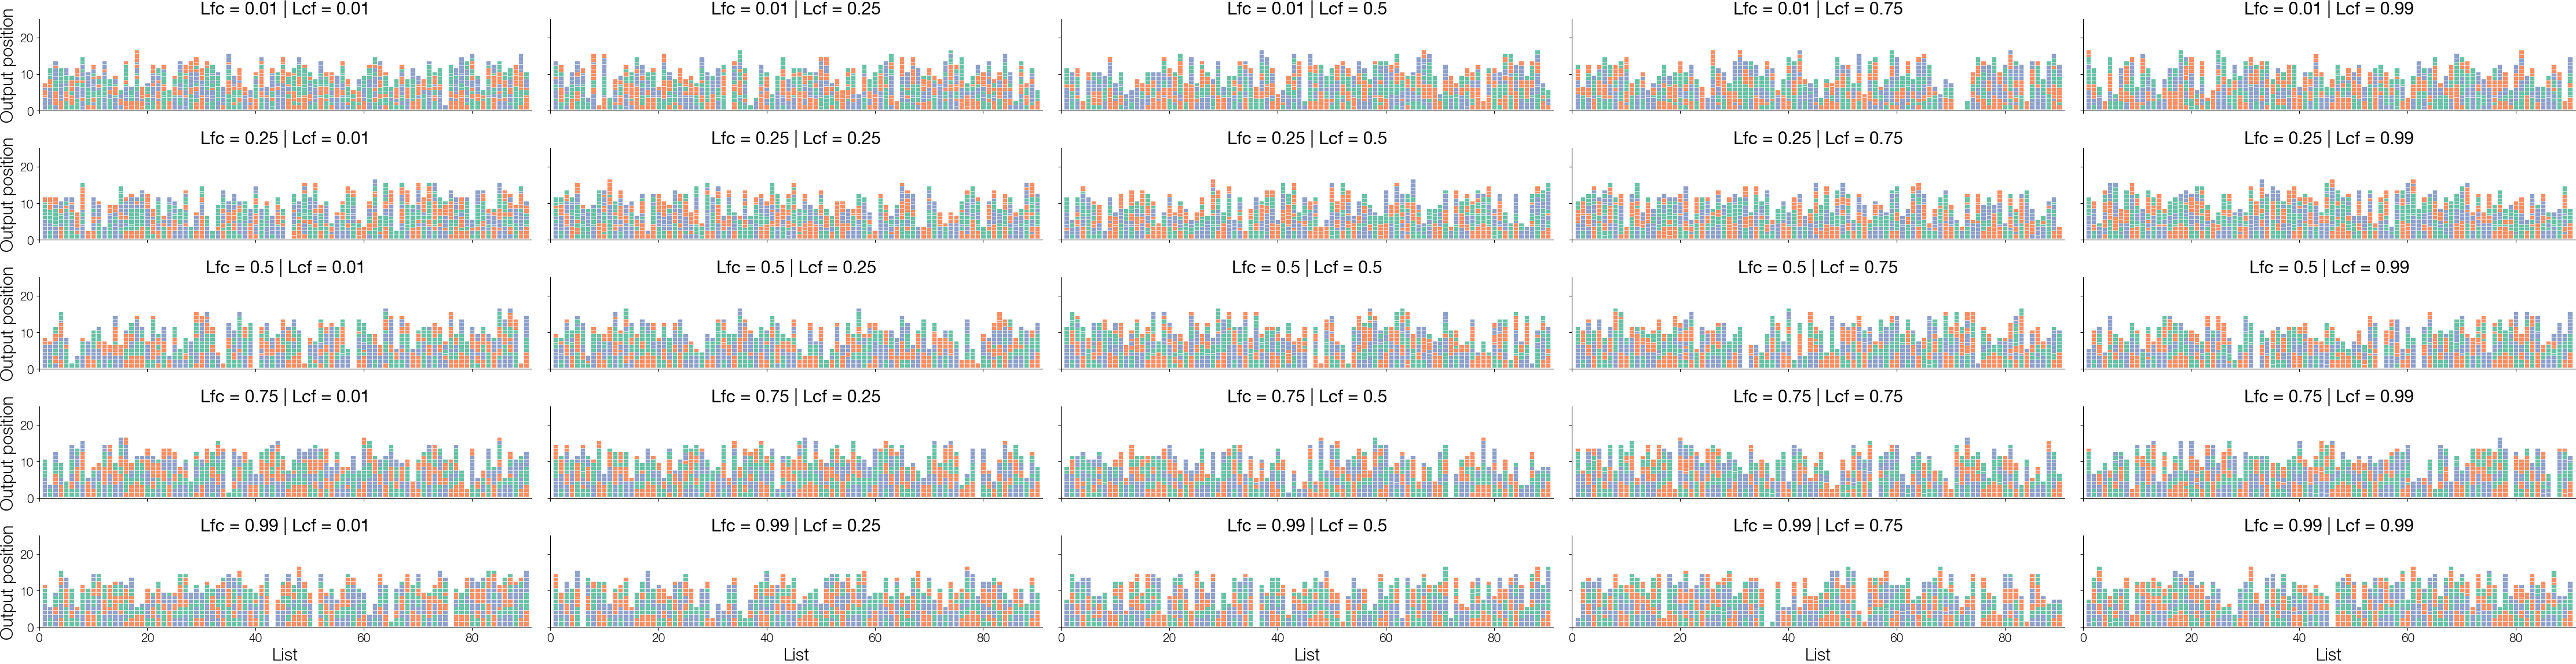

In [6]:
g = fr.plot_raster(
    fr.reset_list(sim.reset_index()),
    hue='category',
    palette=sns.color_palette('Set2', 3),
    row=param_names[0],
    col=param_names[1],
    orientation='horizontal',
    length=9
);

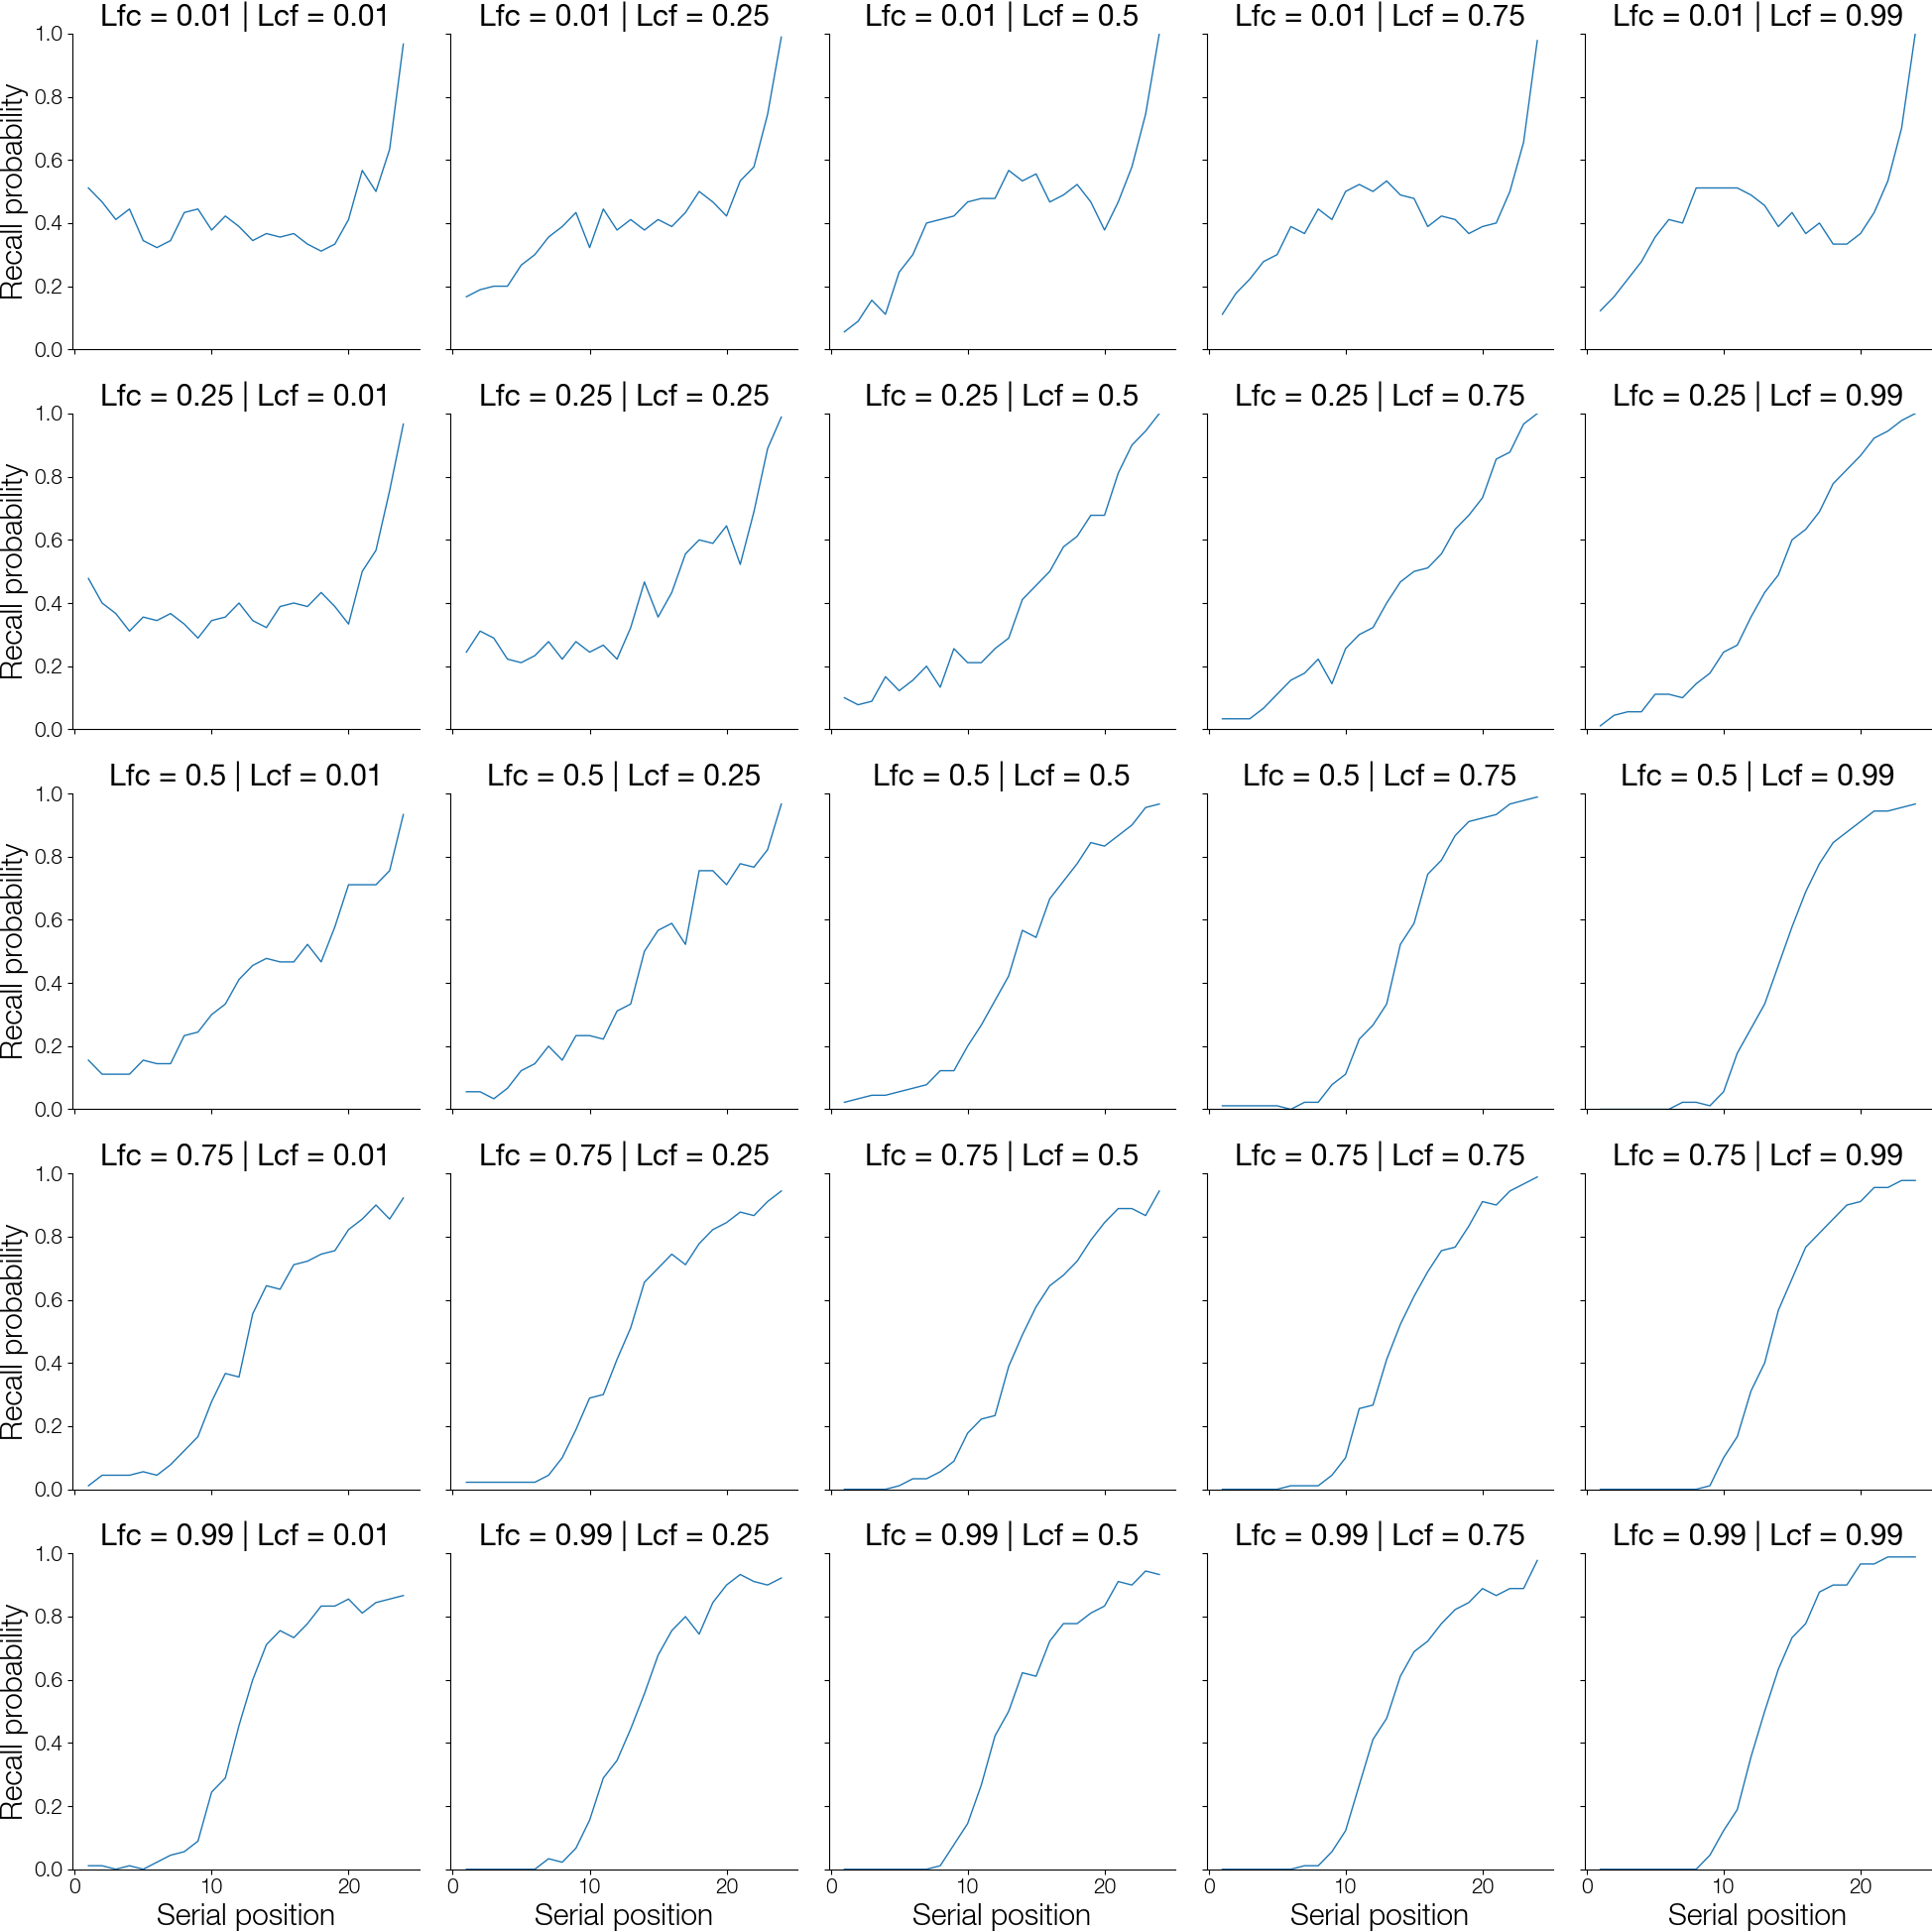

In [7]:
p = sim.groupby(level=[0, 1]).apply(fr.spc)
g = fr.plot_spc(p, row=param_names[0], col=param_names[1], height=4)

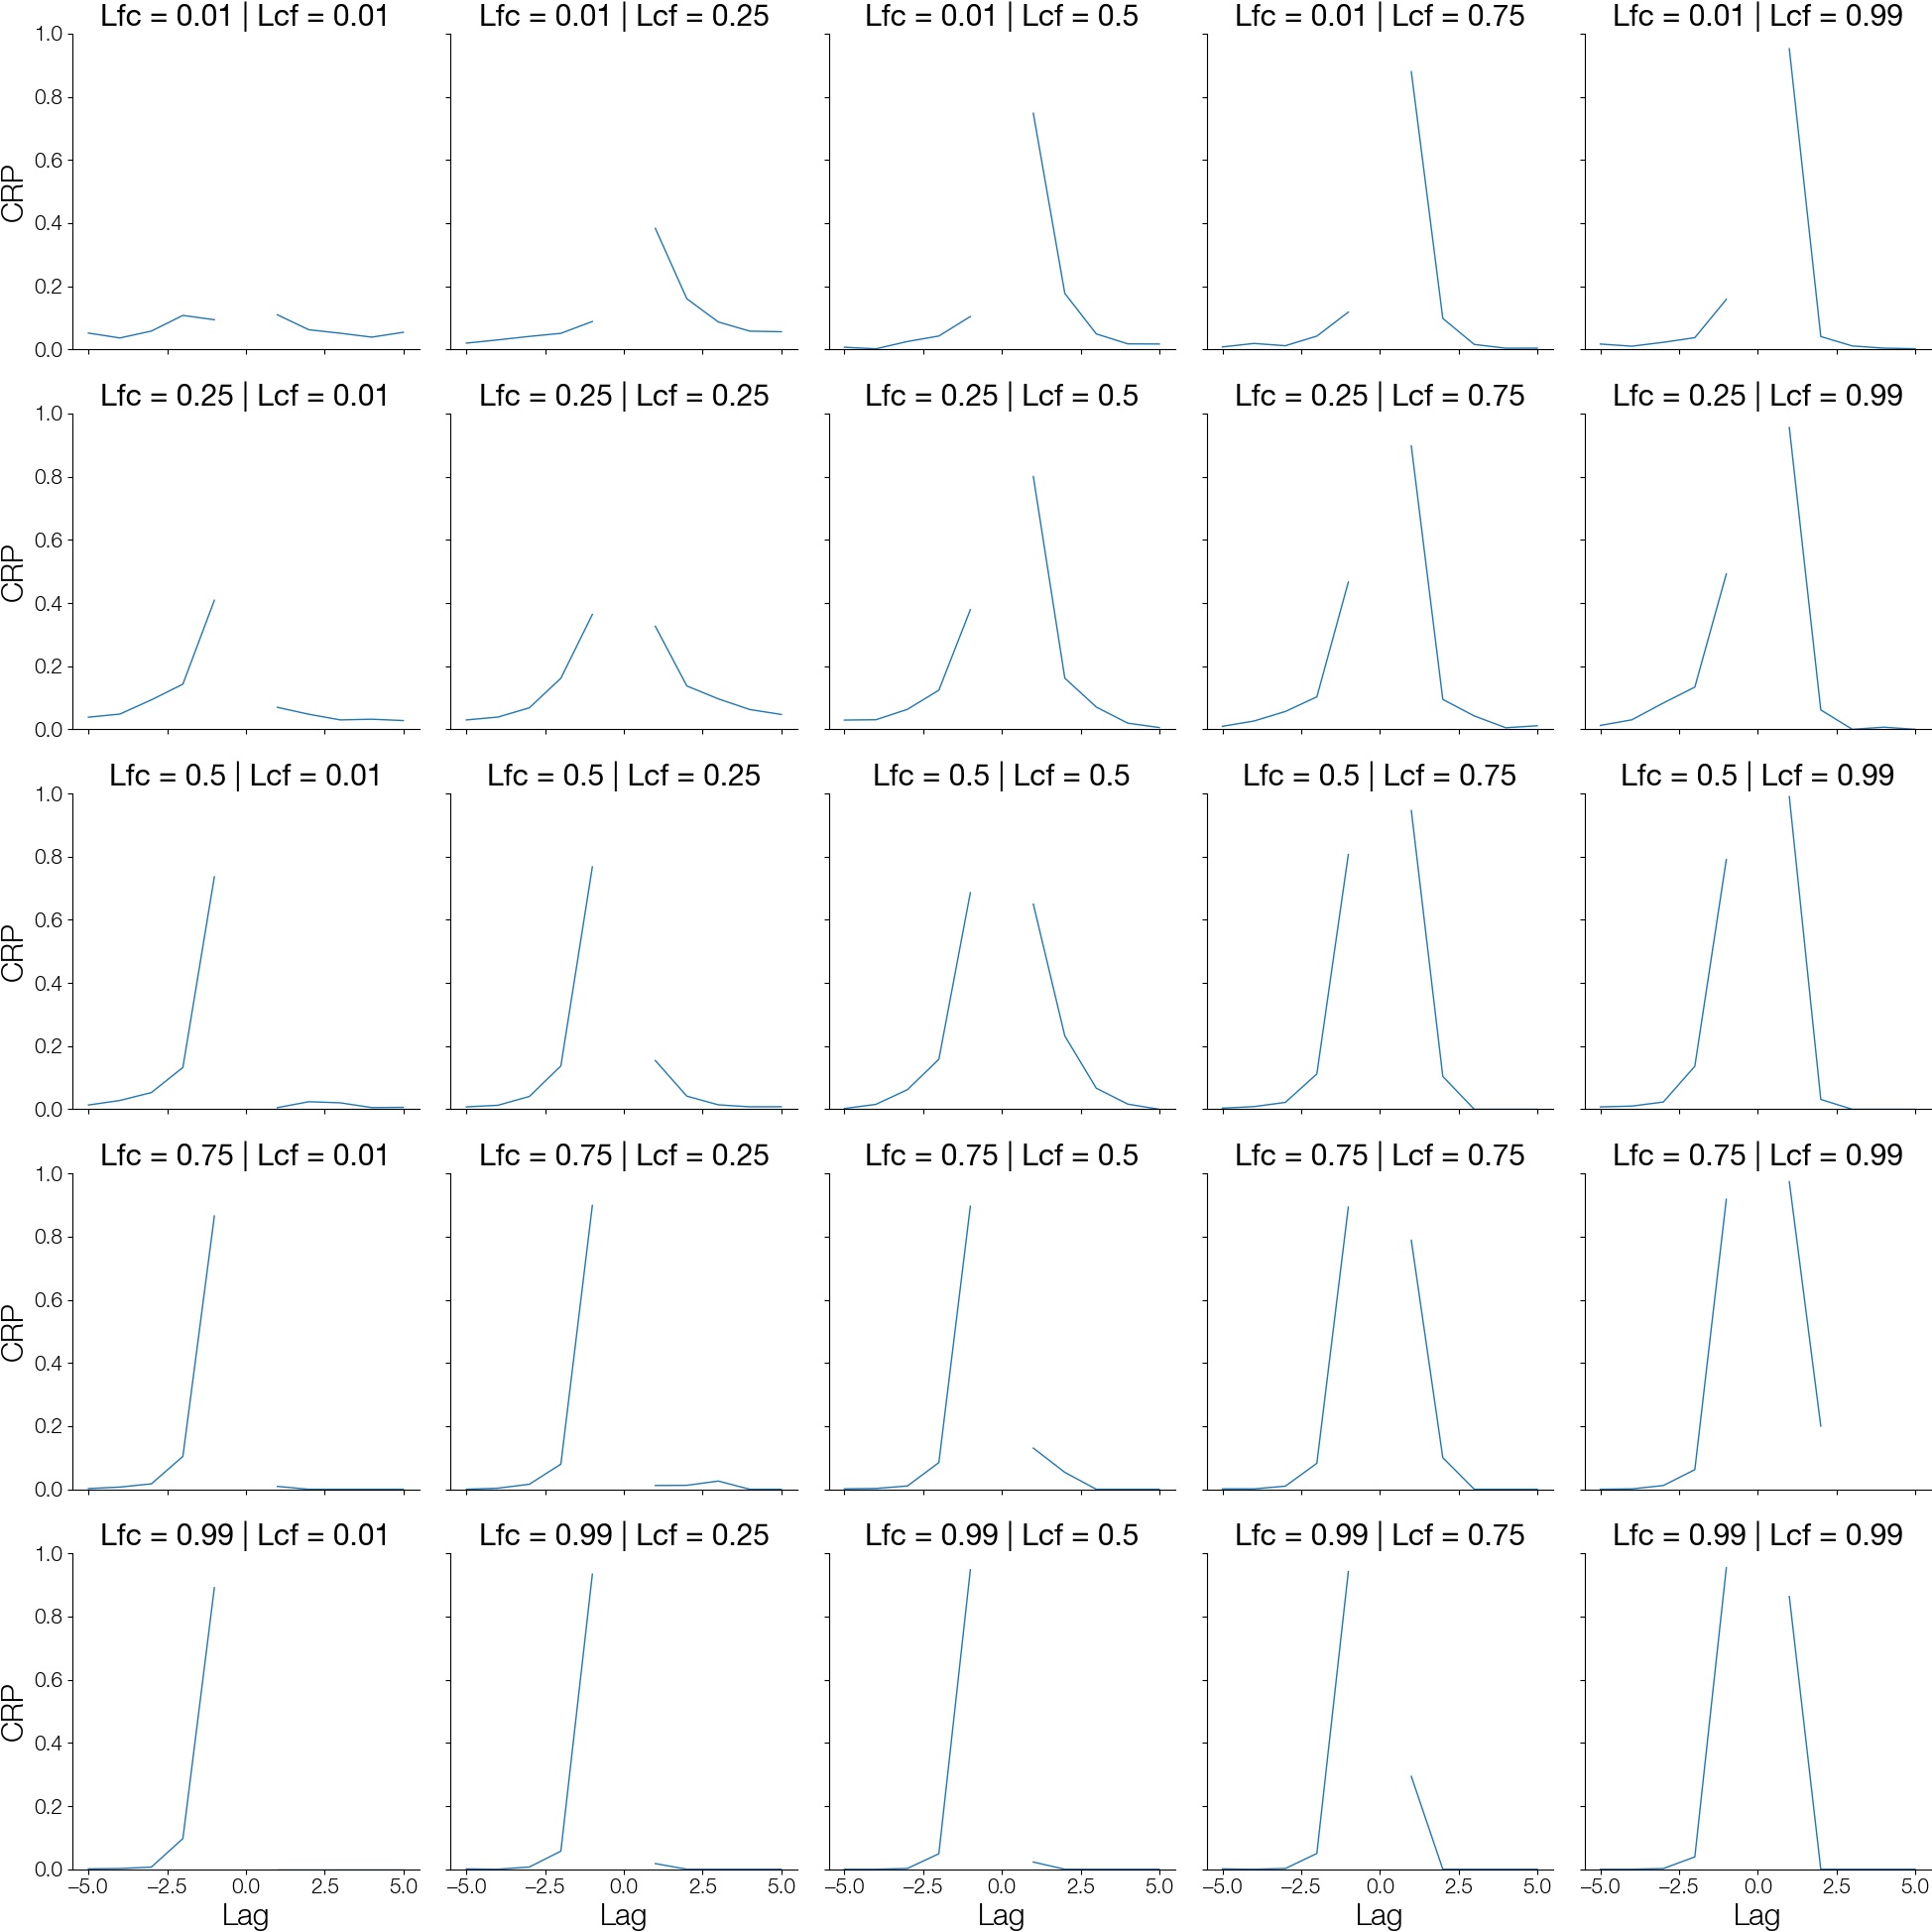

In [8]:
p = sim.groupby(level=[0, 1]).apply(fr.lag_crp)
g = fr.plot_lag_crp(p, row=param_names[0], col=param_names[1], height=4)

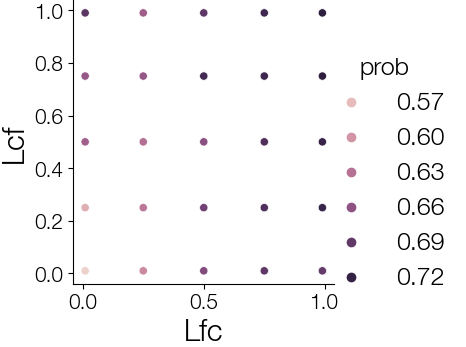

In [9]:
p = sim.groupby(level=[0, 1]).apply(fr.category_crp, category_key='category')
sns.relplot(
    data=p.reset_index(),
    x=param_names[0],
    y=param_names[1],
    hue='prob',
    kind='scatter',
    height=4,
);

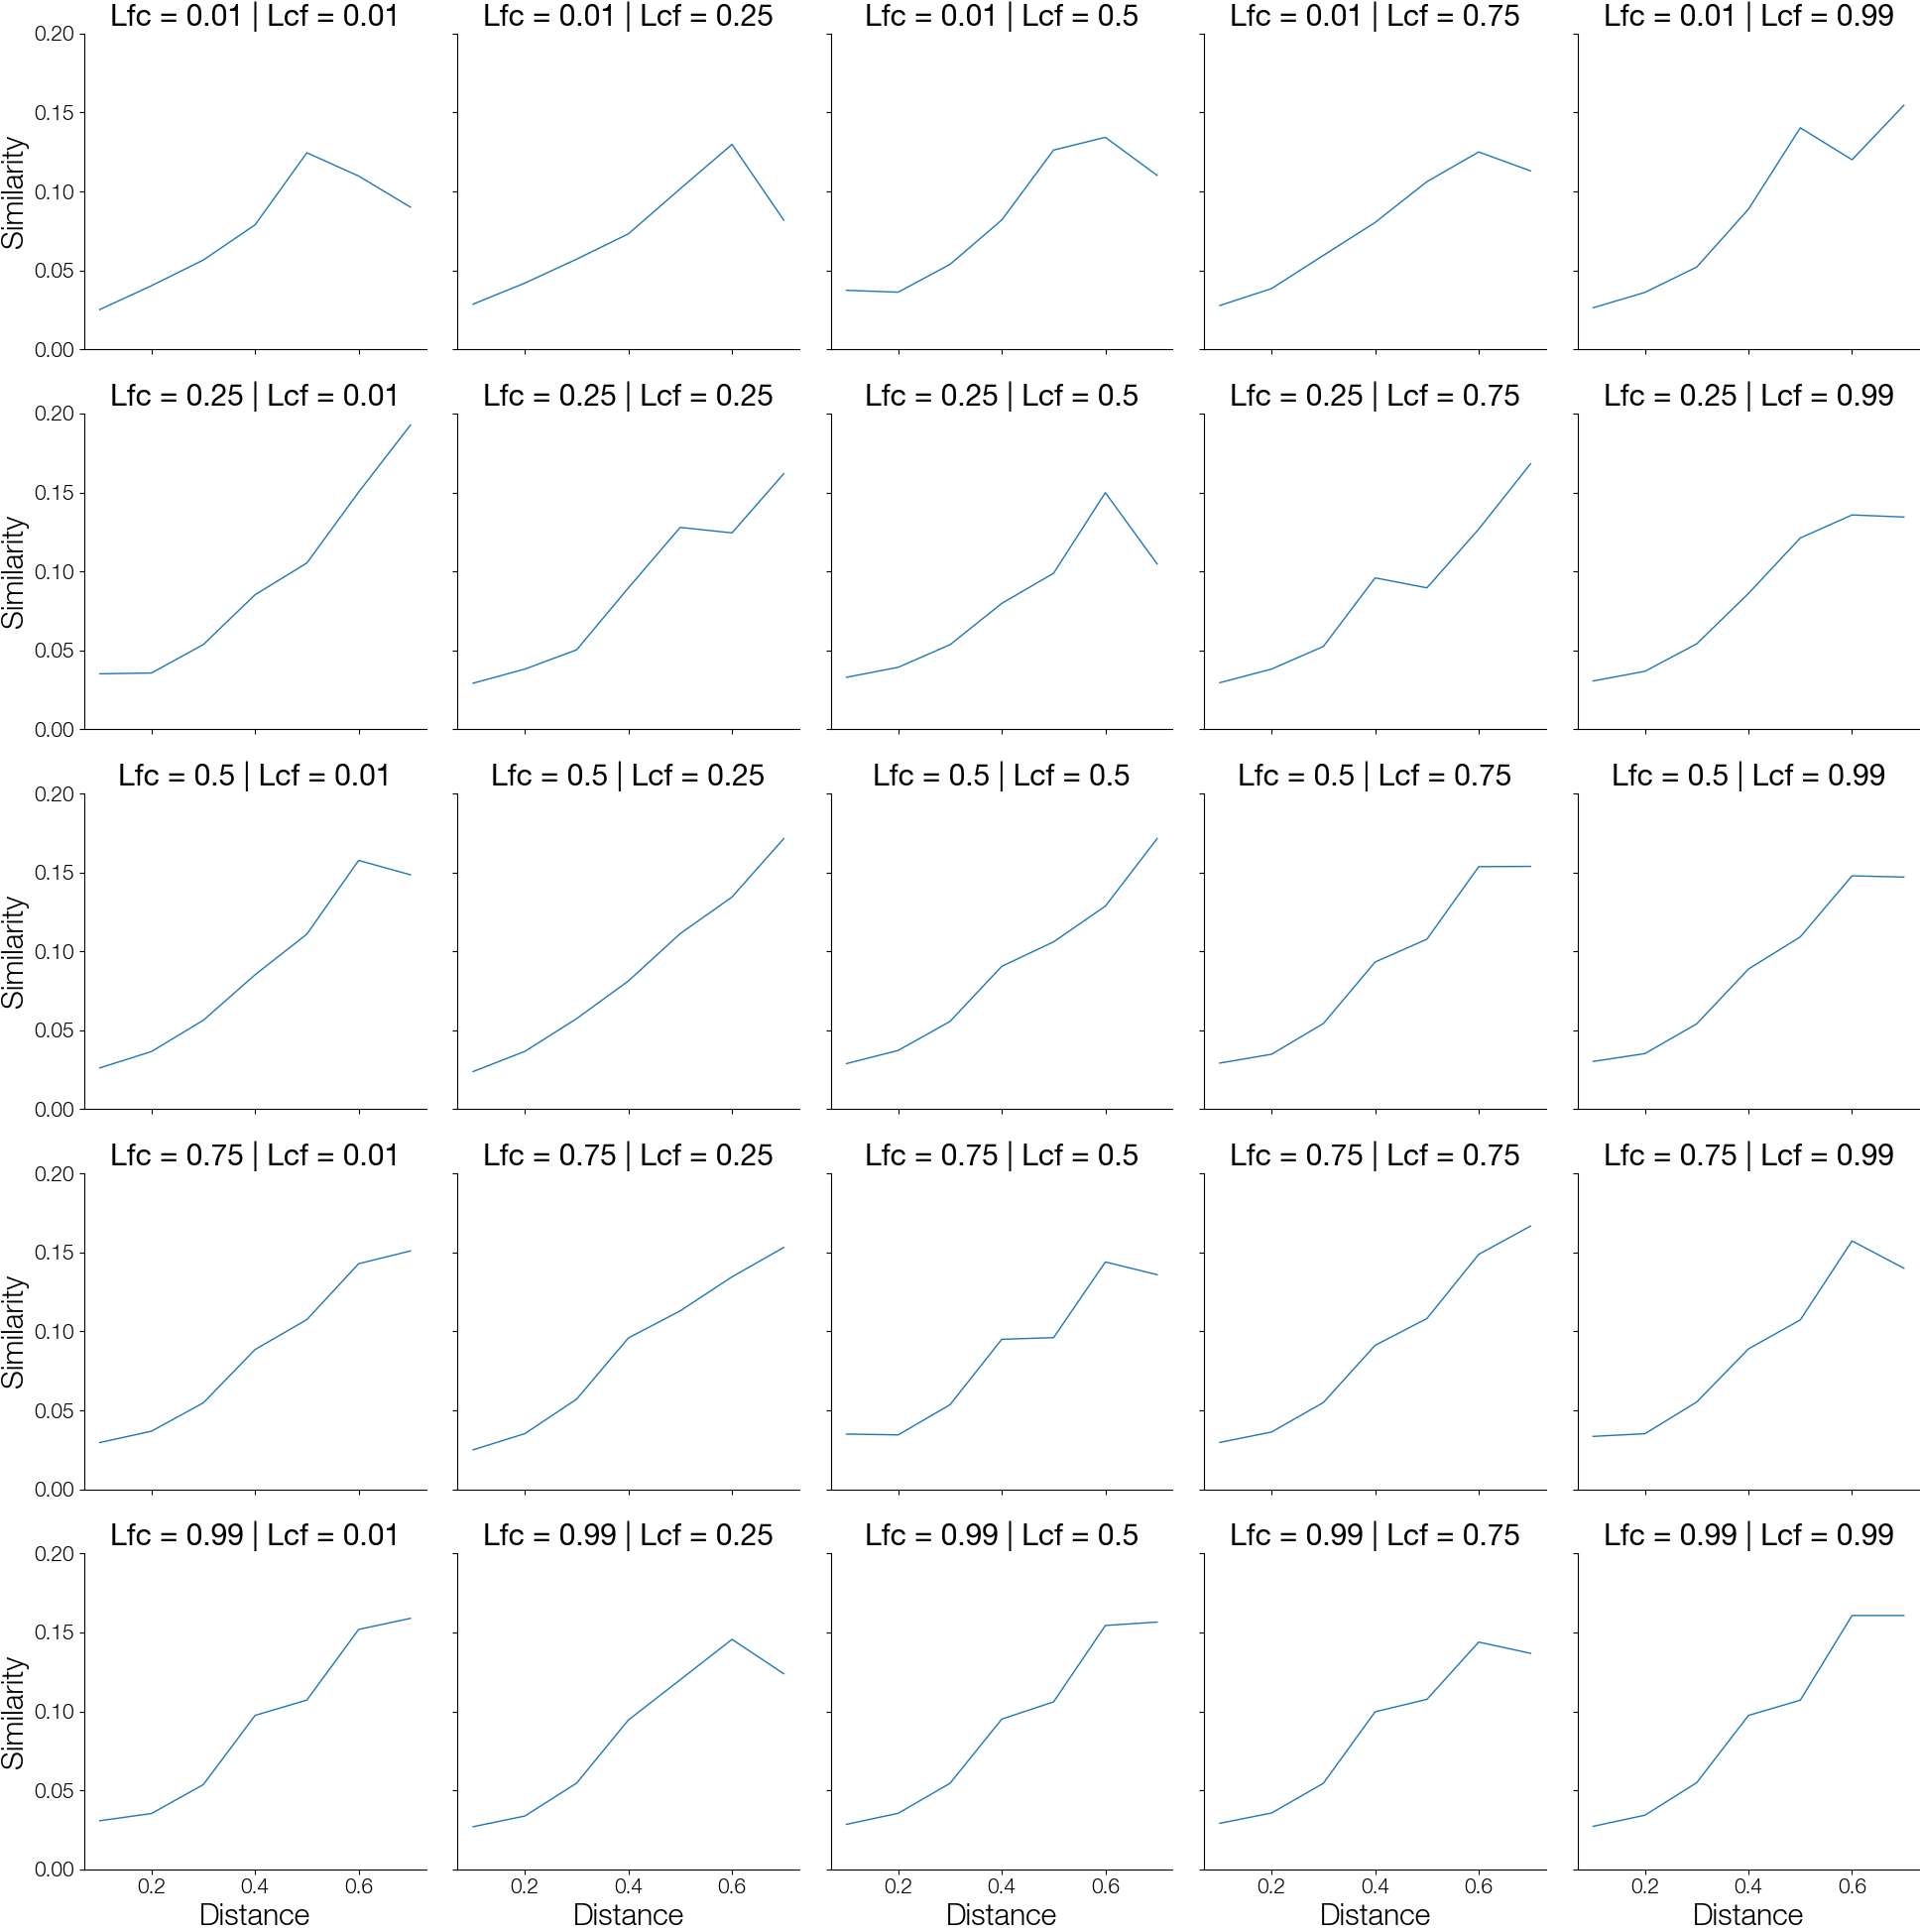

In [10]:
edges = np.linspace(.05, .95, 10)
rsm = patterns['similarity']['use']
sim['item_index'] = fr.pool_index(sim['item'], patterns['items'])
p = sim.groupby(level=[0, 1]).apply(fr.distance_crp, 'item_index', rsm, edges)
g = fr.plot_distance_crp(
    p.reset_index(), row=param_names[0], col=param_names[1], min_samples=100, height=4
)
g.set(ylim=[0, .2], ylabel='Similarity');

In [11]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

pandas : 1.4.2
psifr  : 0.8.0
numpy  : 1.21.4
seaborn: 0.11.2
cymr   : 0.11.2

